In [88]:
import os
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide, under_over, over_under
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### balance cascade

In [180]:
a = np.array([])
a = np.append(a, 1)
a[0]

1.0

In [189]:
class BalanceCascade:
    
    def  __init__(self, classifier = 'LightGBM', num_iter = 10, over_method = None, over_num = 10):
        self.classifier = classifier
        self.num_iter = num_iter
        self.oversampling = True if over_method else False
        self.over_method = over_method
        self.over_num = over_num if over_method else 1

    
    def training(self, train_data, clf_config):
        origin_good = train_data[train_data.GB == 0]
        origin_bad = train_data[train_data.GB == 1] 
        br_0 = (len(origin_bad)*self.over_num) / len(origin_good)
        false_rate = br_0**(1/(self.num_iter - 1))
        
        keep_bad = origin_bad.copy()
        keep_good = {0: origin_good.copy()}
        good = origin_good.copy()
        br_list = np.array([])
        clf_threshold = []
        clf_cascade = {}
        for j in range(self.num_iter):
            br_temp = len(keep_bad) / len(keep_good[j])
            br_list = np.append(br_list, br_temp)
            if self.oversampling:
                print(f'\nIteration {j+1}:')
                temp_combine = pd.concat([keep_good[j], keep_bad], axis = 0)
                over_ratio = np.min([br_temp*self.over_num, 1])
                X, Y = under_over(temp_combine, self.over_method, None, over_ratio, 0)
                resample = pd.concat([X, Y], axis = 1)
                resample = resample.rename({0: 'GB'}, axis = 'columns')
                bad = resample[resample.GB == 1]
                good = resample[resample.GB == 0]
            else:
                bad = keep_bad.copy()
                good = keep_good[j].copy()

            if j != (self.num_iter - 1):
                draw = random.sample(good.index.to_list(), len(bad))
                train_g = good.loc[draw]
                train_b = bad.copy()
                train_combine = pd.concat([train_g, train_b], axis = 0)
            elif j == (self.num_iter - 1):
                train_combine = pd.concat([good, bad], axis = 0)

            valid_g = good.copy()
            train_x, train_y, valid_x, valid_y = label_divide(train_combine, valid_g, 'GB', train_only = False)
            if self.classifier == 'LightGBM':
                clf = LGBMClassifier(**clf_config)
            elif self.classifier == 'RandomForest':
                clf = RandomForestClassifier(**clf_config)
            clf.fit(train_x, train_y)
            predict = clf.predict_proba(valid_x)[:, 1]
            predict_df = pd.DataFrame(dict(predict = predict), index = valid_x.index)
            predict_df = predict_df.sort_values(by = 'predict', ascending = False)
            keep_num = int(len(predict_df)*false_rate)
            keep_index = predict_df.index[:keep_num]
            threshold = predict_df.loc[keep_index[-1]].values[0]
            clf_threshold.append(threshold)
            clf_cascade[j] = clf
            
            if j != (self.num_iter - 1):
                good = good.loc[keep_index]
            keep_good[j+1] = good.copy()
            self.good_data = keep_good
            self.bad_data = keep_bad
            self.threshold = clf_threshold
            self.cascade = clf_cascade
            self.balance_ratio = br_list

        return clf_cascade, clf_threshold
    
    
    def testing(self, test_data, clf_cascade, clf_threshold):
        if isinstance(clf_threshold, int):
            clf_threshold = [clf_threshold]*len(clf_cascade)

        test_x, test_y = label_divide(test_data, 'GB', train_only = True)
        predict_df = pd.DataFrame()
        for i in range(len(clf_cascade)):
            clf = clf_cascade[i]
            predict = clf.predict_proba(test_x)[:, 1]
            answer = (predict > clf_threshold[i]).astype(int)
            predict = pd.DataFrame({str(i): answer})
            predict_df = pd.concat([predict_df, predict], axis = 1)
        predict_y = (predict_df.apply(sum, axis = 1) == len(clf_cascade)).astype(int)
        result = pd.DataFrame(dict(predict = predict_y, truth = test_y))

        return result


def runall_cascade(train_set, test_data, config, classifier = 'LightGBM', num_iter = 10):
    
    num_set = len(train_set)
    table_set = pd.DataFrame()
    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        BC = BalanceCascade(classifier = classifier, num_iter = num_iter)
        clf_cascade, clf_threshold = BC.training(train_set[f'set{i}'], config[f'set{i}'])
        result = BC.testing(test_data, clf_cascade, clf_threshold)
        table = cf_matrix(result, train_set[f'set{i}'].GB)
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
    
    return table_set

## 

### loading hyperparameters & datasets

In [60]:
### training data ###
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (7722, 88)  balance ratio: 10.0
Dimension of dataset 2 : (10538, 88)  balance ratio: 10.0
Dimension of dataset 3 : (8327, 88)  balance ratio: 10.0
Dimension of dataset 4 : (7579, 88)  balance ratio: 10.0
Dimension of dataset 5 : (7602, 88)  balance ratio: 9.83
Dimension of dataset 6 : (7870, 88)  balance ratio: 7.11
Dimension of dataset 7 : (7652, 88)  balance ratio: 9.18
Dimension of dataset 8 : (7590, 88)  balance ratio: 10.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (12672, 97)  balance ratio: 10.0
Dimension of dataset 2 : (17270, 97)  balance ratio: 10.0
Dimension of dataset 3 : (13640, 97)  balance ratio: 10.0
Dimension of dataset 4 : (12419, 97)  balance ratio: 10.0
Dimension of dataset 5 : (12441, 97)  balance rati

In [61]:
TPE_multi = False
base_learner = 'LightGBM'

iteration = 200 if base_learner == 'LightGBM' else 50
TPE = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
with open(f'hyperparameter/20211221/runhist_array_m2m4_m5_3criteria_{base_learner}C_{TPE}_{iteration}.data', 'rb') as f:
    best_paramC = pickle.load(f)

### classifier

#### oversampling in each iteration (for original dataset)

In [207]:
BC = BalanceCascade(classifier = 'LightGBM', num_iter = 30, over_method = 'SMOTEN', over_num = 20)
clf_cascade, clf_threshold = BC.training(run_train['set0'], best_paramC['set0'])
result = BC.testing(run_test, clf_cascade, clf_threshold)
cf_matrix(result, run_train_y['set0'])


Iteration 1:
Size before Oversampling: 157148
Size after Oversampling: 162924

Iteration 2:
Size before Oversampling: 140518
Size after Oversampling: 146294

Iteration 3:
Size before Oversampling: 125651
Size after Oversampling: 131426

Iteration 4:
Size before Oversampling: 112361
Size after Oversampling: 118137

Iteration 5:
Size before Oversampling: 100480
Size after Oversampling: 106256

Iteration 6:
Size before Oversampling: 89858
Size after Oversampling: 95634

Iteration 7:
Size before Oversampling: 80363
Size after Oversampling: 86139

Iteration 8:
Size before Oversampling: 71874
Size after Oversampling: 77650

Iteration 9:
Size before Oversampling: 64285
Size after Oversampling: 70061

Iteration 10:
Size before Oversampling: 57501
Size after Oversampling: 63277

Iteration 11:
Size before Oversampling: 51436
Size after Oversampling: 57212

Iteration 12:
Size before Oversampling: 46014
Size after Oversampling: 51790

Iteration 13:
Size before Oversampling: 41167
Size after Overs

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
0,515.934211,156844.0,304.0,3.0,1710.0,48.0,46888.0,0.001751,0.058824,0.035211,1.670581,0.057782


#### for all datasets


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.01843820016855434

 Dataset 1:
Precision: 0.0015990405756546072 
Recall: 0.1568627450980392 
Aging Rate: 0.10283870172048758

 Dataset 2:
Precision: 0.0015781167806417674 
Recall: 0.17647058823529413 
Aging Rate: 0.1172274866903739

 Dataset 3:
Precision: 0.001006238679814852 
Recall: 0.09803921568627451 
Aging Rate: 0.1021398178790931

 Dataset 4:
Precision: 0.0022839741149600305 
Recall: 0.23529411764705882 
Aging Rate: 0.10799810890254681

 Dataset 5:
Precision: 0.0013173061090070806 
Recall: 0.1568627450980392 
Aging Rate: 0.12483298731731382

 Dataset 6:
Precision: 0.0018430348640761788 
Recall: 0.23529411764705882 
Aging Rate: 0.13383625562704268

 Dataset 7:
Precision: 0.0014110058455956461 
Recall: 0.13725490196078433 
Aging Rate: 0.10197537462229439

 Dataset 8:
Precision: 0.0014989293361884369 
Recall: 0.13725490196078433 
Aging Rate: 0.09599375115624165

 Dataset 9:
Precision: 0.001058057514921324 
Recall: 0.76470588235

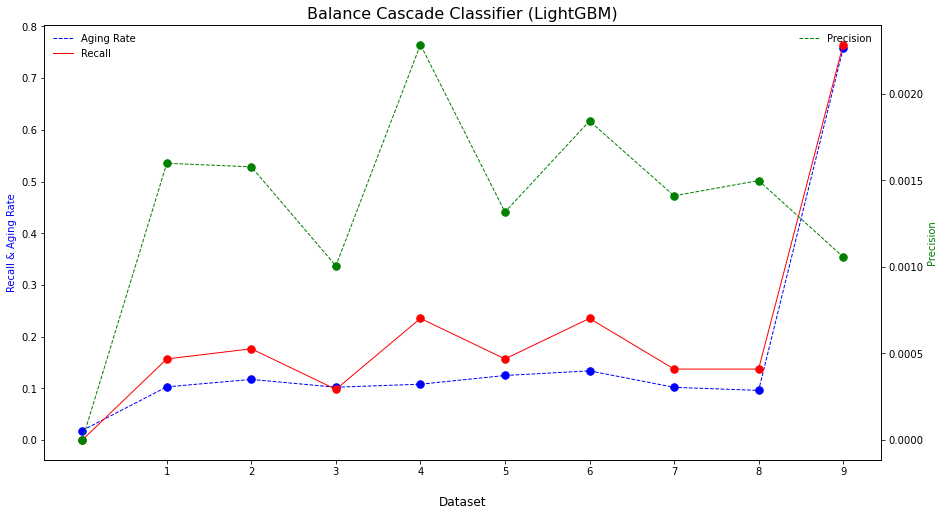

In [201]:
table_setC = runall_cascade(run_train, run_test, best_paramC, classifier = base_learner, num_iter = 30)
line_chart(table_setC, title = f'Balance Cascade Classifier ({base_learner})')

In [63]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,515.934211,156844.0,304.0,9.0,10138.0,42.0,38460.0,0.000887,0.176471,0.208576,0.846074,0.000000
dataset 1,10.000000,30670.0,3067.0,31.0,28252.0,20.0,20346.0,0.001096,0.607843,0.581369,1.045538,0.435010
dataset 2,10.000000,42130.0,4213.0,35.0,27413.0,16.0,21185.0,0.001275,0.686275,0.564205,1.216357,0.546182
dataset 3,10.000000,33360.0,3336.0,26.0,25409.0,25.0,23189.0,0.001022,0.509804,0.522827,0.975091,0.000000
dataset 4,10.000000,30380.0,3038.0,33.0,26914.0,18.0,21684.0,0.001225,0.647059,0.553907,1.168173,0.500749
dataset 5,9.947644,30400.0,3056.0,34.0,28162.0,17.0,20436.0,0.001206,0.666667,0.579580,1.150258,0.510392
dataset 6,7.198674,30400.0,4223.0,31.0,29607.0,20.0,18991.0,0.001046,0.607843,0.609221,0.997738,0.000000
dataset 7,9.178744,30400.0,3312.0,29.0,24675.0,22.0,23923.0,0.001174,0.568627,0.507801,1.119785,0.427218
dataset 8,10.000000,30400.0,3040.0,31.0,27514.0,20.0,21084.0,0.001125,0.607843,0.566199,1.073551,0.443277
dataset 9,10.000000,3040.0,304.0,49.0,45234.0,2.0,3364.0,0.001082,0.960784,0.930810,1.032202,0.681311


### export

In [53]:
savedate = '20220118'

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'BalanceCascade_iter15_random'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'Cascade_iter15_random')